<a href="https://colab.research.google.com/github/Kwanikaze/vpandas/blob/master/VAE_OHE_8digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## Generate Data

In [2]:
def generate_data(num=8):
    """ Generate 'num' number of one-hot encoded integers. """ 
    x_train = np.eye(num)[np.arange(num)]                       # This is a simple way to one-hot encode integers
    
    # Repeat x_train multiple times for training
    x_train = np.repeat(x_train, 100, axis=0)
    
    # The target is x_train itself!
    x_target = x_train.copy()
    return x_train, x_target

In [3]:
num = 8
np.random.seed(10)
x_train, x_target = generate_data(num=num)

In [4]:
print(x_train)
print(np.shape(x_train))
print(np.shape(x_target))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(800, 8)
(800, 8)


## Variational Autoencoder Parameters

In [5]:
#Parameters
latent_dims = 3
num_epochs = 2000
batch_size = 64
learning_rate = 1e-3
use_gpu = True
variational_beta = 0.00001 #tuned

## VAE Definition
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=0psoODlF9S_Y

https://stats.stackexchange.com/questions/361643/sampling-z-in-vae

https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.fc1 = nn.Linear(num, latent_dims) # why have this additional fc layer?
        self.fc_mu = nn.Linear(latent_dims, latent_dims)
        self.fc_logvar = nn.Linear(latent_dims, latent_dims)
        self.fc_out = nn.Linear(latent_dims,num)

    def encode(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        if z.size()[0] == self.latent_dims: #resize from [3] to [1,3]
          z = z.view(1, self.latent_dims)
        softmax = nn.Softmax(dim=1)
        recon = softmax(self.fc_out(z))
        return recon

    def forward(self, x, latent_dims):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def latent(self,x,latent_dims):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z
        
    def sample(self, num_samples):
      # ignore latent_mu, latent_logvar, instead generate z values from standard normal
      z = torch.randn(num_samples, self.latent_dims)
      z = z.to(device)
      samples = self.decode(z)
      return samples

def vae_loss(batch_recon, x_batch_targets, mu, logvar):
  criterion = nn.CrossEntropyLoss()
  CE = criterion(batch_recon, x_batch_targets)
  #print(CE)
  #BCE = F.binary_cross_entropy(recon, x, reduction='sum') #one hot encoded input
  KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
  #print(KLd)
  return CE,variational_beta*KLd, CE + variational_beta*KLd

In [7]:
def trainVAE(VAE, latent_dims):
  VAE.train()
  x_train, x_target = generate_data(num=num)
  inds = list(range(x_train.shape[0]))
  N = x_train.shape[0] # 800
  freq = num_epochs // 10 # floor division

  loss_hist = []
  x_train = Variable(torch.from_numpy(x_train))
  x_target = Variable(torch.from_numpy(x_target))
  for epoch in range(num_epochs):
      inds = np.random.permutation(inds)
      x_train = x_train[inds]
      x_train = x_train.to(device)
      x_target = x_target[inds]
      x_target = x_target.to(device)
      
      loss = 0
      CE = 0
      KLd = 0
      num_batches = N / batch_size
      for b in range(0, N, batch_size):
          #get the mini-batch
          x_batch = x_train[b: b+batch_size]
          x_target_batch = x_target[b: b+batch_size]
          
          #feed forward
          batch_recon,latent_mu,latent_logvar = VAE(x=x_batch.float(),latent_dims = latent_dims)
          
          # Error
          #Convert x_batch from OHE vectors to single scalar for target class, of each sample in batch 
          _, x_batch_targets = x_batch.max(dim=1)
          train_CE, train_KLd, train_loss = vae_loss(batch_recon, x_batch_targets, latent_mu, latent_logvar)
          #print(batch_recon.size())
          #print(x_batch_targets.size())
          loss += train_loss.item() / N # update epoch loss
          CE += train_CE.item() / N 
          KLd += train_KLd.item() / N 

          #Backprop the error, compute the gradient
          optimizer.zero_grad()
          train_loss.backward()
          
          #update parameters based on gradient
          optimizer.step()
          
      #Record loss per epoch        
      loss_hist.append(loss)
      
      if epoch % freq == 0:
          print()
          print("Epoch %d/%d\t CE: %.5f, KLd: %.5f, Train loss=%.5f" % (epoch + 1, num_epochs,CE,KLd, loss), end='\t', flush=True)
          
          #Test with all training data
          VAE.eval()
          train_recon, train_mu, train_logvar = VAE(x = x_train.float(),latent_dims=latent_dims)
          _, x_targets = x_target.max(dim=1)
          CE,KLd,test_loss = vae_loss(train_recon, x_targets, train_mu, train_logvar)
          print("\t CE: {:.5f}, KLd: {:.5f}, Test loss: {:.5f}".format(CE,KLd,test_loss.item()), end='')
      
  print("\nTraining finished!")

## Latent dimensions set to 3

In [8]:
#  use gpu if available
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
VAE = VariationalAutoencoder(latent_dims=3)
VAE = VAE.to(device)
num_params = sum(p.numel() for p in VAE.parameters() if p.requires_grad)
print(VAE.parameters)
print("Number of parameters: %d" % num_params) #8*3 + 3 = 27, 3*8 + 8 = 32, 27+32

# optimizer object
optimizer = torch.optim.Adam(params = VAE.parameters(), lr = learning_rate)
#criterion = nn.CrossEntropyLoss()    # for target, does not accept a OHE vector
#criterion = nn.NLLLoss()

trainVAE(VAE, latent_dims=3)

<bound method Module.parameters of VariationalAutoencoder(
  (fc1): Linear(in_features=8, out_features=3, bias=True)
  (fc_mu): Linear(in_features=3, out_features=3, bias=True)
  (fc_logvar): Linear(in_features=3, out_features=3, bias=True)
  (fc_out): Linear(in_features=3, out_features=8, bias=True)
)>
Number of parameters: 83

Epoch 1/2000	 CE: 0.03385, KLd: 0.00001, Train loss=0.03386		 CE: 2.08214, KLd: 0.00606, Test loss: 2.08820
Epoch 201/2000	 CE: 0.02226, KLd: 0.00014, Train loss=0.02240		 CE: 1.36708, KLd: 0.11540, Test loss: 1.48248
Epoch 401/2000	 CE: 0.02079, KLd: 0.00017, Train loss=0.02096		 CE: 1.27924, KLd: 0.13924, Test loss: 1.41848
Epoch 601/2000	 CE: 0.02073, KLd: 0.00013, Train loss=0.02086		 CE: 1.27571, KLd: 0.10389, Test loss: 1.37961
Epoch 801/2000	 CE: 0.02072, KLd: 0.00008, Train loss=0.02080		 CE: 1.27505, KLd: 0.06663, Test loss: 1.34167
Epoch 1001/2000	 CE: 0.02071, KLd: 0.00007, Train loss=0.02078		 CE: 1.27451, KLd: 0.05324, Test loss: 1.32775
Epoch 1201

KL Divergence increases, then decreases. Cross Entropy loss (reconstruction term of the ELBO) steadily decreases.

In [9]:
print("Print prediction results:")
x_test = np.eye(num)[np.arange(num)]                        # Test data (one-hot encoded)
x_test = Variable(torch.from_numpy(x_test))
x_test = x_test.to(device)
#np.set_printoptions(2)
for x in x_test:
    print("\tInput: {} \t Output: {}".format(x.cpu().detach().numpy(), np.round(VAE(x=x.float(),latent_dims=3)[0].cpu().detach().numpy(),decimals=2)))

Print prediction results:
	Input: [1. 0. 0. 0. 0. 0. 0. 0.] 	 Output: [[1. 0. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 1. 0. 0. 0. 0. 0. 0.] 	 Output: [[0. 1. 0. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 1. 0. 0. 0. 0. 0.] 	 Output: [[0. 0. 1. 0. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 1. 0. 0. 0. 0.] 	 Output: [[0. 0. 0. 1. 0. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 1. 0. 0. 0.] 	 Output: [[0. 0. 0. 0. 1. 0. 0. 0.]]
	Input: [0. 0. 0. 0. 0. 1. 0. 0.] 	 Output: [[0. 0. 0. 0. 0. 1. 0. 0.]]
	Input: [0. 0. 0. 0. 0. 0. 1. 0.] 	 Output: [[0. 0. 0. 0. 0. 0. 1. 0.]]
	Input: [0. 0. 0. 0. 0. 0. 0. 1.] 	 Output: [[0. 0. 0. 0. 0. 0. 0. 1.]]


## Extract intermediate features using Forward Hook

In [10]:
def inside_layer(self, input1, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('\tInside ' + self.__class__.__name__ + ' forward')
    #print('\t input:', input1[0].cpu().detach().numpy())
    print('\t input rounded to 2 decimals:', np.round(input1[0].cpu().detach().numpy(),2))
    #print('\t output:', output.cpu().detach().numpy())
    print('\t output rounded to 2 decimals:', np.round(output.cpu().detach().numpy(),2))

In [11]:
mu_hook = VAE.fc_mu.register_forward_hook(inside_layer)
for x in x_test:
    print('INPUT: {}'.format(x.cpu().detach().numpy()))
    out = VAE(x=x.float(),latent_dims=3)
    #print(out)
mu_hook.remove() #remove hook after use

INPUT: [1. 0. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.04 0.28 0.6 ]
	 output rounded to 2 decimals: [ 2.15  0.22 -1.22]
INPUT: [0. 1. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.61 0.7  0.07]
	 output rounded to 2 decimals: [-2.09  1.34  0.08]
INPUT: [0. 0. 1. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.95 0.84 0.56]
	 output rounded to 2 decimals: [-1.56 -1.39  0.67]
INPUT: [0. 0. 0. 1. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.5  0.01 0.47]
	 output rounded to 2 decimals: [ 2.09 -0.41  1.61]
INPUT: [0. 0. 0. 0. 1. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.01 0.39 0.13]
	 output rounded to 2 decimals: [ 0.22  2.3  -1.4 ]
INPUT: [0. 0. 0. 0. 0. 1. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [0.4  0.89 0.63]
	 output rounded to 2 decimals: [-0.76 -0.4  -1.77]
INPUT: [0. 0. 0. 0. 0. 0. 1. 0.]
	Inside Linear forward
	 input 

In [12]:
decoder_hook = VAE.fc_out.register_forward_hook(inside_layer)
for x in x_test:
    print('INPUT: {}'.format(x.cpu().detach().numpy()))
    out = VAE(x=x.float(),latent_dims=3)
    #print(out)
decoder_hook.remove() #remove hook after use

INPUT: [1. 0. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[ 2.75  0.23 -1.28]]
	 output rounded to 2 decimals: [[ 25.14 -15.64 -20.54  11.17   7.84   2.93  -9.57   9.27]]
INPUT: [0. 1. 0. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[-1.56  1.15 -0.08]]
	 output rounded to 2 decimals: [[ -9.56  15.12   3.14 -14.44   6.63   5.3    4.46 -10.45]]
INPUT: [0. 0. 1. 0. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[-1.8  -1.06  1.15]]
	 output rounded to 2 decimals: [[-17.81   6.96  18.21  -7.21 -15.73  -0.04   8.21   1.61]]
INPUT: [0. 0. 0. 1. 0. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[ 2.1  -0.43  1.08]]
	 output rounded to 2 decimals: [[ 11.01 -14.08  -7.67  19.72  -8.89 -10.82   6.36   8.95]]
INPUT: [0. 0. 0. 0. 1. 0. 0. 0.]
	Inside Linear forward
	 input rounded to 2 decimals: [[-0.09  2.1  -1.5 ]]
	 output rounded to 2 decimals: [[  7.12  10.09 -13.52 -12.44  21.27  10.    -4.54 -10.

## Generate Samples
https://www.jeremyjordan.me/variational-autoencoders/

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [13]:
samples = VAE.sample(num_samples=1000)
#print(samples[0:5])
print(np.round(samples[0:9].cpu().detach().numpy(),2))

[[0.   0.77 0.   0.   0.17 0.06 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.04 0.   0.   0.   0.   0.   0.   0.96]
 [0.   0.16 0.77 0.   0.   0.06 0.   0.  ]
 [0.   0.   0.   0.   0.   0.07 0.   0.93]
 [0.01 0.   0.   0.   0.01 0.98 0.   0.  ]
 [0.   0.   0.02 0.   0.   0.01 0.   0.97]
 [0.6  0.   0.   0.4  0.   0.   0.   0.  ]
 [0.   0.   0.12 0.03 0.   0.   0.06 0.79]]


Samples sum to 1. Most are almost OHE vectors.

## Visualize Latent Space

Can view tradeoff in continuous latent space vs focussed point distributions as varying weight placed on KL Divergence.

In [14]:
x_train, x_target = generate_data(num=num)
x_train = Variable(torch.from_numpy(x_train))

np_z = np.empty(0)
for x in x_train:
  z = VAE.latent(x.float(),latent_dims)
  #print(z)
  np_z = np.concatenate((np_z, z.cpu().detach().numpy()))
np_z = np_z.reshape(800,3)
#print(np_z[:,0])

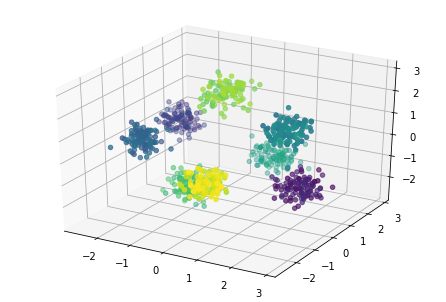

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
t = np.arange(800)
ax.scatter(np_z[:,0], np_z[:,1], np_z[:,2], c = t)

In [16]:
from sklearn.manifold import TSNE
z_embedded = TSNE(n_components=2).fit_transform(np_z)
z_embedded.shape

(800, 2)

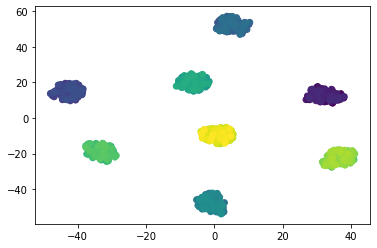

In [17]:
plt.scatter(z_embedded[:,0],z_embedded[:,1],c=t)